# What's Cooking Machine Learning Project

In [ ]:
# Import the libraries we'll use below.
import numpy as np
import json
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import tensorflow as tf
from tensorflow import keras
from collections import Counter
from sklearn import preprocessing 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


In [ ]:
train_file = '/content/gdrive/My Drive/whats-cooking/train.json'

train_data = pd.read_json(train_file, orient='columns')
train_data = train_data[:25000]
train_data.head(10)
print (train_data)

          id      cuisine                                        ingredients
0      10259        greek  [romaine lettuce, black olives, grape tomatoes...
1      25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2      20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3      22213       indian                [water, vegetable oil, wheat, salt]
4      13162       indian  [black pepper, shallots, cornflour, cayenne pe...
...      ...          ...                                                ...
24995  20514      chinese  [sliced carrots, hot chili sauce, shrimp, grou...
24996  30037     filipino  [butter, shrimp, pepper, salt, hot red pepper ...
24997  31397     japanese  [fennel seeds, fresh curry leaves, sesame oil,...
24998  10242      mexican  [water, red wine vinegar, salt, oregano, pico ...
24999  36176      mexican  [kosher salt, jalapeno chilies, garlic, corn b...

[25000 rows x 3 columns]


## Creating a baseline
For our data, we want to make a baseline that will predict the cuisine. So, we'll say that the cuisine that occurs the most is the predicted cuisine

In [ ]:

train_data['cuisine'].value_counts(normalize=True) * 100

italian         19.706341
mexican         16.186453
southern_us     10.861367
indian           7.550158
chinese          6.720471
french           6.652587
cajun_creole     3.886961
thai             3.869362
japanese         3.577714
greek            2.954191
spanish          2.486549
korean           2.086790
vietnamese       2.074219
moroccan         2.064163
british          2.021421
filipino         1.898225
irish            1.676975
jamaican         1.322472
russian          1.229446
brazilian        1.174134
Name: cuisine, dtype: float64

As shown above, the cuisine that occurs the most is Italian with about 19.7 percent, so it's safe to assume that a given cuisine is an Italian one. So let's write that to our .csv file

In [ ]:
test_file = '/content/gdrive/My Drive/whats-cooking/test.json'


test_data = pd.read_json(test_file, orient='columns')
test_data.head()

# baseline = pd.DataFrame(data=test_data['id'].copy())
# baseline['cuisine'] = 'italian'

# baseline.to_csv('/content/gdrive/My Drive/whats-cooking/baseline submission.csv', index=False,header=True)


,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


# Data Analysis
Let's start off by getting a visualization of our training data by plotting a bar graph of each cuisine

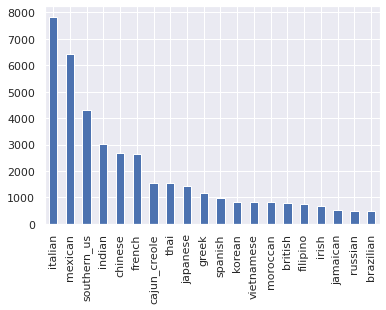

In [ ]:
train_data['cuisine'].value_counts().plot(kind='bar')

As you can see, there's more italian dishes than the others, which may affect our data as we do our next analysis: seeing how a specific ingredient appears in each cuisine. Let's choose garlic for example.
Since there's more Italian dishes, let's take the relative frequency of each occurrence better represent the data.

italian         1667
mexican         1479
chinese          948
indian           832
thai             499
cajun_creole     487
korean           373
southern_us      343
filipino         335
vietnamese       304
greek            267
french           256
japanese         184
spanish          181
moroccan         172
jamaican         151
brazilian         96
irish             54
british           45
russian           25
Name: cuisine, dtype: int64


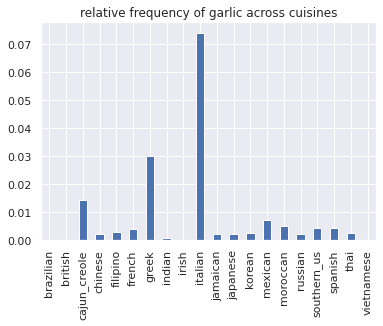

In [ ]:
train_data['ingredients_string'] = train_data['ingredients'].map("-".join)
print(train_data[train_data['ingredients_string'].str.contains("garlic-")]['cuisine'].value_counts())
(train_data[train_data['ingredients_string'].str.contains("pasta-")]['cuisine'].value_counts() / train_data['cuisine'].value_counts()).plot(kind='bar',title='relative frequency of garlic across cuisines')


Unsurprisingly, garlic makes up over 70% of italian cuisines. Could we use this for other ingredients and see what happens?

In [ ]:
#counts how many times each ingredient shows up for every cuisine
ingredientCount = {}
for cuisine in train_data['cuisine'].unique():
    ingredientCount[cuisine] = Counter()
    key = (train_data['cuisine'] == cuisine)
    for ingredients in train_data[key]['ingredients']:
        ingredientCount[cuisine].update(ingredients)

#makes a new dataframe for the top 10 ingredients for each cuisine
top10_df = pd.DataFrame([[items[0] for items in ingredientCount[cuisine].most_common(10)] for cuisine in ingredientCount],
            index=[cuisine for cuisine in ingredientCount],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10_df.head(20)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
greek,salt,olive oil,dried oregano,garlic cloves,feta cheese crumbles,extra-virgin olive oil,fresh lemon juice,ground black pepper,garlic,pepper
southern_us,salt,butter,all-purpose flour,sugar,large eggs,baking powder,water,unsalted butter,milk,buttermilk
filipino,salt,garlic,water,onions,soy sauce,pepper,oil,sugar,carrots,ground black pepper
indian,salt,onions,garam masala,water,ground turmeric,garlic,cumin seed,ground cumin,vegetable oil,oil
jamaican,salt,onions,water,garlic,ground allspice,pepper,scallions,dried thyme,black pepper,garlic cloves
spanish,salt,olive oil,garlic cloves,extra-virgin olive oil,onions,water,tomatoes,ground black pepper,red bell pepper,pepper
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic,ground black pepper,extra-virgin olive oil,onions,water,butter
mexican,salt,onions,ground cumin,garlic,olive oil,chili powder,jalapeno chilies,sour cream,avocado,corn tortillas
chinese,soy sauce,sesame oil,salt,corn starch,sugar,garlic,water,green onions,vegetable oil,scallions
british,salt,all-purpose flour,butter,milk,eggs,unsalted butter,sugar,onions,baking powder,large eggs


As you can see, we have plotted how many recipes each cuisine has and created a new dataframe that contains the top 10 ingredients for each cuisine. From this we have a couple of findings:



*   We see that the #1 ingredient for all cuisines is salt or a salty flavor (Chinese, Japanese & Korean cuisines use soy sauce while Thai & Vietnamese cuisine uses fish sauce)

* Ingredients like salt, sugar, water, eggs, etc. are also very common among all cuisines  


*   This also shows us that ingredients could be the same but have different names, for example, large eggs vs. eggs and garlic vs. garlic cloves.

From here we can explore exactly which of each cuisine's top 10 ingredients are more exclusive to that specific cuisine.



In [ ]:
train_data['all_ingredients'] = train_data['ingredients'].map(",".join)
test_data['all_ingredients'] = train_data['ingredients'].map(",".join)

# topIngredients = np.unique(top10_df.values.ravel())

# fig, axes = plt.subplots(8, 8, figsize=(50, 60))
# for ingredient, ax_index in zip(topIngredients, range(64)):
#     ingredients = train_data['all_ingredients'].str.contains(ingredient)
#     relative_freq = (train_data[ingredients]['cuisine'].value_counts() / train_data['cuisine'].value_counts())
#     relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)





From here we can see what ingredients are unique to one cuisine such as:


*   Avocado (Mexican)
*   Cachaca (Brazilian)
*   Corn starch (Chinese)
*   Corn tortillas (Mexican)
*   Feta cheese crumbles (Greek)
*   Garam masala (Indian)
*   Grated parmesan cheese (Italian)
*   Green bell pepper (Cajun creole)
*   Ground allspice (Jamaican)
*   Ground ginger (Moroccan)
*   Mirin (Japanese)
*   Sesame seeds (Korean)

While there are several ingredients that are very popular across all cuisines like:


*   All purpose flour
*   Baking soda
*   Black pepper
*   Butter
*   Eggs
*   Garlic
*   Oil
*   Onion
*   Salt
*   Sugar
*   Water

























To prepare our training set for learning, we want to preprocess our data. We can do this by giving each unique ingredient an ID number


In [ ]:
ingredientLst = []
for ingredients in train_data['ingredients']:
  for ingredient in ingredients:
    ingredientLst.append(ingredient)
ingredientLst = set(ingredientLst)
ingredientsMap = {}
count = 1
for ingredient in ingredientLst:
  ingredientsMap[ingredient] = count
  count += 1
print(ingredientsMap) 

{'octopuses': 1, 'osetra caviar': 2, 'Green Giant™ sliced mushrooms': 3, 'boneless pork loin': 4, 'dark miso': 5, 'low fat reduced sodium pasta sauce': 6, 'crushed peppercorn': 7, 'Mexican lager beer': 8, 'white beans': 9, 'açai powder': 10, 'crab sticks': 11, 'fresh oregano leaves': 12, 'mild Italian sausage': 13, 'rib roast': 14, 'duck fat': 15, 'teriyaki marinade': 16, 'blood': 17, 'capocollo': 18, 'ground cashew': 19, 'liquid': 20, 'color food orang': 21, 'goat cheese': 22, 'grated parmesan romano': 23, 'Kerrygold Pure Irish Butter': 24, 'toasted wheat germ': 25, 'Argo Corn Starch': 26, 'tomato chutney': 27, 'taco toppings': 28, 'Nakano Seasoned Rice Vinegar': 29, 'meat marinade': 30, 'daikon sprouts': 31, 'warm water': 32, 'ground allspice': 33, 'saffron threads': 34, 'reduced fat cream cheese': 35, 'shredded reduced fat reduced sodium swiss cheese': 36, 'chuno sauce': 37, 'whipping cream': 38, 'whole wheat pasta shells': 39, 'Sriracha': 40, 'black walnut': 41, 'scallions': 42, 'm

In [ ]:
#Mapping each unique ingredient to a unique value by putting them
# in a set and then turning that set into a dictionary
#there's probably a much easier way of doing this
ingredientLst = set([])
for ingredients in train_data['ingredients']:
    ingredientLst.update(ingredients)
ingredientsMap = {}
count = 1
for ingredient in ingredientLst:
  ingredientsMap[ingredient] = count
  count += 1
def create_X_data(X_arr,data):
  for ingredients in data['ingredients']:
    this_ingredients = []
    for ingredient in ingredients:
      num = ingredientsMap.get(ingredient)
      this_ingredients.append(num)
    X_arr.append(this_ingredients)
  return X_arr
train_X = create_X_data([],train_data)

test_x = create_X_data([], test_data)
print(test_x)

print(train_X)


In [ ]:
cv = CountVectorizer()
# X_train = cv.fit_transform(train_data['all_ingredients'].values).toarray()
# foods = cv.vocabulary_
# print(X_train[0])

# #shows all ingredients w/ unique ID
# # print(foods)
# X_test = cv.fit_transform(test_data['all_ingredients'].values)
# test_X = create_X_data([],test_data)
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
Y_train = np.array(label_encoder.fit_transform(train_data['cuisine'])) 
print(Y_train)  

[ 6 16  4 ... 11 13 13]


Padding Data

In [ ]:
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))
  
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

# Pad and truncate to 10 tokens.


# # Check the padded output.
# print('Length of X_train[0]:', len(X_train[0]))
# print('Length of X_train_padded[0]:', len(X_train_padded[0]))
# print(X_train_padded[0])

TypeError: ignored

In [ ]:
# Keras has a util to create one-hot encodings.
X_train_padded = pad_data(train_X, max_length=10)
X_test_padded = pad_data(test_x, max_length=10)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
X_train_one_hot = tf.keras.utils.to_categorical(X_train_padded)
print('X_train_one_hot shape:', X_train_one_hot.shape)

# # Fit the model.
# history = model.fit(
#   x = X_train,  # one-hot training data
#   y = Y_train,          # corresponding binary labels
#   epochs=5,             # number of passes through the training data
#   batch_size=64,        # mini-batch size
#   validation_split=0.1, # use a fraction of the examples for validation
#   verbose=0            # display some progress output during training
#   )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
# history = pd.DataFrame(history.history)
# plot_history(history)

TypeError: ignored

In [ ]:
def build_onehot_model(average_over_positions=True):
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.compat.v1.set_random_seed(0)

  model = tf.keras.Sequential()
  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=20,                     # output dim (for binary classification)
      activation="softmax"         # sigmoid activation for classification
  ))

  model.compile(loss='sparse_categorical_crossentropy',   # this is a classification task
                optimizer='adam',             # fancy optimizer
                metrics='accuracy')

  return model

In [ ]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()


Epoch 1/5
141/141 [==============================] - 1s 6ms/step - loss: 2.9235 - accuracy: 0.3351 - val_loss: 2.8510 - val_accuracy: 0.4210
Epoch 2/5
141/141 [==============================] - 1s 6ms/step - loss: 2.7888 - accuracy: 0.4117 - val_loss: 2.7313 - val_accuracy: 0.4030
Epoch 3/5
141/141 [==============================] - 1s 5ms/step - loss: 2.6784 - accuracy: 0.3913 - val_loss: 2.6336 - val_accuracy: 0.3830
Epoch 4/5
141/141 [==============================] - 1s 5ms/step - loss: 2.5881 - accuracy: 0.3828 - val_loss: 2.5539 - val_accuracy: 0.3740
Epoch 5/5
141/141 [==============================] - 1s 5ms/step - loss: 2.5129 - accuracy: 0.3753 - val_loss: 2.4880 - val_accuracy: 0.3700


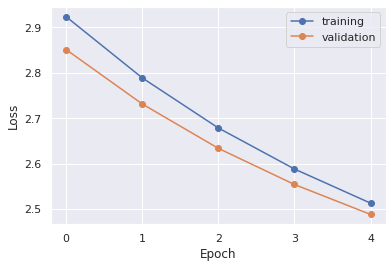

In [ ]:
model = build_onehot_model()
history = model.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,      # corresponding binary labels
   epochs=5,             # number of passes through the training data
   batch_size=64,        # mini-batch size
   validation_split=0.1, # use a fraction of the examples for validation
   verbose=1             # display some progress output during training
  )
# history.score()
history = pd.DataFrame(history.history)
plot_history(history)

Epoch 1/35
313/313 [==============================] - 1s 2ms/step - loss: 2.5612 - accuracy: 0.2320 - val_loss: 2.3923 - val_accuracy: 0.3106
Epoch 2/35
313/313 [==============================] - 1s 2ms/step - loss: 2.2535 - accuracy: 0.3377 - val_loss: 2.1438 - val_accuracy: 0.3652
Epoch 3/35
313/313 [==============================] - 1s 2ms/step - loss: 2.0547 - accuracy: 0.3920 - val_loss: 2.0453 - val_accuracy: 0.3898
Epoch 4/35
313/313 [==============================] - 1s 2ms/step - loss: 1.9455 - accuracy: 0.4204 - val_loss: 1.9754 - val_accuracy: 0.4150
Epoch 5/35
313/313 [==============================] - 1s 2ms/step - loss: 1.8755 - accuracy: 0.4400 - val_loss: 1.9462 - val_accuracy: 0.4248
Epoch 6/35
313/313 [==============================] - 1s 2ms/step - loss: 1.8248 - accuracy: 0.4526 - val_loss: 1.9319 - val_accuracy: 0.4306
Epoch 7/35
313/313 [==============================] - 1s 2ms/step - loss: 1.7835 - accuracy: 0.4640 - val_loss: 1.9182 - val_accuracy: 0.4284
Epoch 

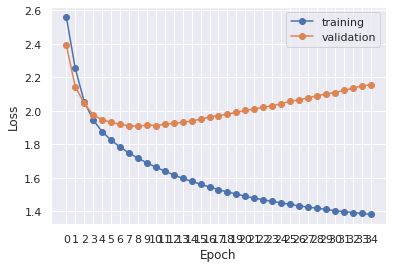

In [ ]:
def build_embeddings_model(average_over_positions=False,
                           vocab_size=1000,
                           sequence_length=10,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.compat.v1.set_random_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  # model.add(tf.keras.layers.Dense(
  #     units=20,                     # output dim (for binary classification)
  #     activation="sigmoid"         # apply the sigmoid function!
  # ))

  model.add(tf.keras.layers.Dense(
      units=20,                     # output dim (for binary classification)
      activation="softmax"         # apply the sigmoid function!
  ))

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='adam',
                metrics='accuracy')

  return model

model = build_embeddings_model(average_over_positions=False,
                               vocab_size=1000,
                               sequence_length=10,
                               embedding_dim=64)

history = model.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=35,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.2, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

history = pd.DataFrame(history.history)
plot_history(history)

In [ ]:


# from sklearn.metrics import confusion_matrix

# plt.figure(figsize=(10, 10))

# cm = confusion_matrix(y_test, logistic.predict(X_test))
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plt.imshow(cm_normalized, interpolation='nearest')
# plt.title("confusion matrix")
# plt.colorbar(shrink=0.3)
# cuisines = df_train['cuisine'].value_counts().index
# tick_marks = np.arange(len(cuisines))
# plt.xticks(tick_marks, cuisines, rotation=90)
# plt.yticks(tick_marks, cuisines)
# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')

ValueError: ignored



*   Experiment & compare models w/ confusion matrices
*   Plot training & validation loss -- check for overfitting
*   Use regularization techniques
*   Compare to baseline



